In [1]:
%env HF_TOKEN=your-huggingface-token-here
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENROUTER_API_KEY=your_openrouter_api_key_here


env: HF_TOKEN=your-huggingface-token-here
env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [2]:
from ai.rubric import get_structured_scorer

score_ai_response = get_structured_scorer(model_name="meta-llama/llama-4-maverick")
# score_ai_response = get_structured_scorer(model_name="anthropic/claude-opus-4")

In [3]:
from datasets import load_dataset

# Remove problematic arguments; just use default config and let datasets handle cache
downloaded_dataset = load_dataset('profoz/airbnb-policy-scenarios')
downloaded_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'situation', 'solution', 'document_id', 'article'],
        num_rows: 809
    })
    test: Dataset({
        features: ['url', 'situation', 'solution', 'document_id', 'article'],
        num_rows: 232
    })
})

In [4]:
downloaded_dataset['test'][0]['situation']

'A traveler is interested in renting a cottage for a month in the Outer Banks and wants to know if Airbnb offers this type of rental and how to find it.'

In [5]:
import pandas as pd

before_ft_df = pd.read_csv("./before_ft.csv")
before_ft_df.head()

,situation,solution,response
0,A traveler is interested in renting a cottage ...,"According to the article, Airbnb offers a vari...","<think>\nOkay, the user is asking about rentin..."
1,A guest is concerned about a neighborhood issu...,"According to the Airbnb Help Center, there is ...","<think>\nOkay, the user is a guest who's worri..."
2,A guest has a reservation for a beachfront pro...,According to Airbnb's Major Disruptive Events ...,"<think>\nOkay, let's tackle this scenario. The..."
3,A new host in Europe wants to know what regula...,"According to the article, Airbnb provides resp...","<think>\nOkay, the user is a new host in Europ..."
4,A user from California is concerned that their...,"According to the article, if you reside in Cal...","<think>\nOkay, the user is from California and..."


In [6]:
before_ft_df.iloc[0]['response'].split('/think>')[0].split('<think>')[-1].strip()

'Okay, the user is asking about renting a cottage for a month in the Outer Banks on Airbnb. Let me break this down.\n\nFirst, I need to confirm if Airbnb allows month-long rentals. I remember that Airbnb does have long-term stays, but there might be some restrictions. The user is specifically asking about the Outer Banks, which is a popular tourist area, so maybe there are local regulations or host preferences that affect this.\n\nI should check if there are any policies about the minimum stay. From what I know, some hosts set minimum stays, especially for longer periods. Also, the Outer Banks might have specific rules about short-term rentals, so I should mention that. Maybe some areas restrict rentals to a certain number of days or require permits.\n\nI need to guide the user on how to find these listings. They can use the search filters on Airbnb, like selecting "month" under the "minimum stay" option. But I should also note that not all hosts might offer such long stays, so they mi

In [7]:

rubric_result = score_ai_response(
    question=downloaded_dataset['test'][0]['situation'],
    # ai_response=before_ft_df.iloc[0]['response'].split('/think>')[0].strip(),
    ai_response=before_ft_df.iloc[0]['response'].split('/think>')[0].split('<think>')[-1].strip(),
    ground_truth=before_ft_df.iloc[0]['solution']
)

In [8]:
print("Rubric Evaluation Result")
print("=" * 40)
print(f"Reasoning:\n{rubric_result.reasoning}")
print("-" * 40)
print(f"Score: {rubric_result.score}")


Rubric Evaluation Result
Reasoning:
The AI response provides a detailed and step-by-step guide on how to find a cottage rental for a month in the Outer Banks on Airbnb. It confirms that Airbnb allows long-term stays and provides instructions on using search filters, contacting hosts, and reviewing listing descriptions. Although the AI response includes additional information about host policies, local regulations, and the importance of reading listing terms, the core of the response aligns with the ground truth by affirming that Airbnb offers cottage rentals in the Outer Banks and explaining how to search for them. The AI response goes beyond the ground truth by providing extra details and considerations, but it does not contradict the ground truth. The main point of the ground truth - that the traveler can search for 'Outer Banks Cottage rentals' on Airbnb - is implicitly covered, as the AI suggests using relevant search filters. Therefore, the AI response mostly matches the ground tr

In [9]:
k = None

In [10]:
results = []

In [11]:
rubric_result

ScoreResponse(reasoning="The AI response provides a detailed and step-by-step guide on how to find a cottage rental for a month in the Outer Banks on Airbnb. It confirms that Airbnb allows long-term stays and provides instructions on using search filters, contacting hosts, and reviewing listing descriptions. Although the AI response includes additional information about host policies, local regulations, and the importance of reading listing terms, the core of the response aligns with the ground truth by affirming that Airbnb offers cottage rentals in the Outer Banks and explaining how to search for them. The AI response goes beyond the ground truth by providing extra details and considerations, but it does not contradict the ground truth. The main point of the ground truth - that the traveler can search for 'Outer Banks Cottage rentals' on Airbnb - is implicitly covered, as the AI suggests using relevant search filters. Therefore, the AI response mostly matches the ground truth but inc

In [ ]:
from tqdm import tqdm

for i in tqdm(range(len(before_ft_df.head(k)))):
    if len(results) > 0 and i < len(results):
        continue
    reasoning_rubric_result = score_ai_response(
        question=downloaded_dataset['test'][i]['situation'],
        ai_response=before_ft_df.iloc[i]['response'].split('/think>')[0].split('<think>')[-1].strip(),
        ground_truth=downloaded_dataset['test'][i]['solution']
    )

    answer_rubric_result = score_ai_response(
        question=downloaded_dataset['test'][i]['situation'],
        ai_response=before_ft_df.iloc[i]['response'].split('/think>')[-1].strip(),
        ground_truth=downloaded_dataset['test'][i]['solution']
    )
    results.append({
        'reasoning': reasoning_rubric_result.score,
        'answer': answer_rubric_result.score,
    })
    if len(results) % 20 == 0:
        avg_score = sum([r['reasoning'] + r['answer'] for r in results]) / (2 * len(results))
        print(f"Average score so far: {avg_score:.2f}")

 17%|█▋        | 40/232 [01:05<09:36,  3.00s/it]

Average score so far: 1.32


 26%|██▌       | 60/232 [02:24<11:58,  4.18s/it]

Average score so far: 1.37


 34%|███▍      | 80/232 [03:43<10:24,  4.11s/it]

Average score so far: 1.31


 43%|████▎     | 100/232 [04:45<06:57,  3.16s/it]

Average score so far: 1.34


 52%|█████▏    | 120/232 [05:58<06:26,  3.46s/it]

Average score so far: 1.36


 60%|██████    | 140/232 [07:05<05:15,  3.43s/it]

Average score so far: 1.37


 69%|██████▉   | 160/232 [08:09<03:28,  2.90s/it]

Average score so far: 1.37


 78%|███████▊  | 180/232 [09:14<03:00,  3.48s/it]

Average score so far: 1.37


 86%|████████▌ | 200/232 [10:22<01:54,  3.59s/it]

Average score so far: 1.38


 95%|█████████▍| 220/232 [11:32<00:42,  3.56s/it]

Average score so far: 1.40


100%|██████████| 232/232 [12:15<00:00,  3.17s/it]


In [14]:
after_ft_df = pd.read_csv("./after_ft (1).csv")

after_ft_df.head()

,situation,solution,response
0,A traveler is interested in renting a cottage ...,"According to the article, Airbnb offers a vari...","<think>\nOkay, the user wants to rent a cottag..."
1,A guest is concerned about a neighborhood issu...,"According to the Airbnb Help Center, there is ...","<think>\nOkay, the user is asking about report..."
2,A guest has a reservation for a beachfront pro...,According to Airbnb's Major Disruptive Events ...,"<think>\nOkay, so the user is asking about a s..."
3,A new host in Europe wants to know what regula...,"According to the article, Airbnb provides resp...","<think>\nOkay, the user is a new host in Europ..."
4,A user from California is concerned that their...,"According to the article, if you reside in Cal...","<think>\nOkay, the user is from California and..."


In [15]:
after_results = []

In [16]:
for i in tqdm(range(len(after_ft_df.head(k)))):
    # If after_results is not empty, skip already processed items
    if len(after_results) > 0 and i < len(after_results):
        continue
    reasoning_rubric_result = score_ai_response(
        question=downloaded_dataset['test'][i]['situation'],
        ai_response=after_ft_df.iloc[i]['response'].split('/think>')[0].split('<think>')[-1].strip(),
        ground_truth=downloaded_dataset['test'][i]['solution']
    )
    answer_rubric_result = score_ai_response(
        question=downloaded_dataset['test'][i]['situation'],
        ai_response=after_ft_df.iloc[i]['response'].split('/think>')[-1].strip(),
        ground_truth=downloaded_dataset['test'][i]['solution']
    )
    after_results.append({
        'reasoning': reasoning_rubric_result.score,
        'answer': answer_rubric_result.score,
    })
    if len(after_results) % 20 == 0:
        avg_score = sum([r['reasoning'] + r['answer'] for r in after_results]) / (2 * len(after_results))
        print(f"Average score so far: {avg_score:.2f}")

  9%|▊         | 20/232 [01:16<12:29,  3.54s/it]

Average score so far: 1.77


 17%|█▋        | 40/232 [02:34<12:12,  3.82s/it]

Average score so far: 1.76


 26%|██▌       | 60/232 [04:09<13:21,  4.66s/it]

Average score so far: 1.80


 34%|███▍      | 80/232 [05:26<10:48,  4.27s/it]

Average score so far: 1.73


 43%|████▎     | 100/232 [06:41<07:53,  3.59s/it]

Average score so far: 1.69


 52%|█████▏    | 120/232 [07:52<06:35,  3.53s/it]

Average score so far: 1.67


 60%|██████    | 140/232 [09:09<06:21,  4.15s/it]

Average score so far: 1.68


 69%|██████▉   | 160/232 [10:32<05:29,  4.58s/it]

Average score so far: 1.66


 78%|███████▊  | 180/232 [11:56<03:56,  4.55s/it]

Average score so far: 1.66


 86%|████████▌ | 200/232 [13:15<02:15,  4.24s/it]

Average score so far: 1.66


 95%|█████████▍| 220/232 [14:29<00:42,  3.55s/it]

Average score so far: 1.67


100%|██████████| 232/232 [15:15<00:00,  3.94s/it]


In [17]:
if len(results) > len(after_results):
    print("results is longer than after_results")
    results = results[:len(after_results)]
else:
    print("after_results is longer than results")
    after_results = after_results[:len(results)]

after_results is longer than results


In [18]:
len(results), len(after_results)

(232, 232)

In [19]:
results[0]

{'reasoning': 2, 'answer': 2}

In [20]:
combined_df = pd.DataFrame({
    "reasoning_score_before": [r['reasoning'] for r in results],
    "answer_score_before": [r['answer'] for r in results],
    "reasoning_score_after": [r['reasoning'] for r in after_results],
    "answer_score_after": [r['answer'] for r in after_results],
})

combined_df.head()


,reasoning_score_before,answer_score_before,reasoning_score_after,answer_score_after
0,2,2,2,3
1,1,1,1,2
2,1,1,2,2
3,2,1,2,2
4,1,2,1,2


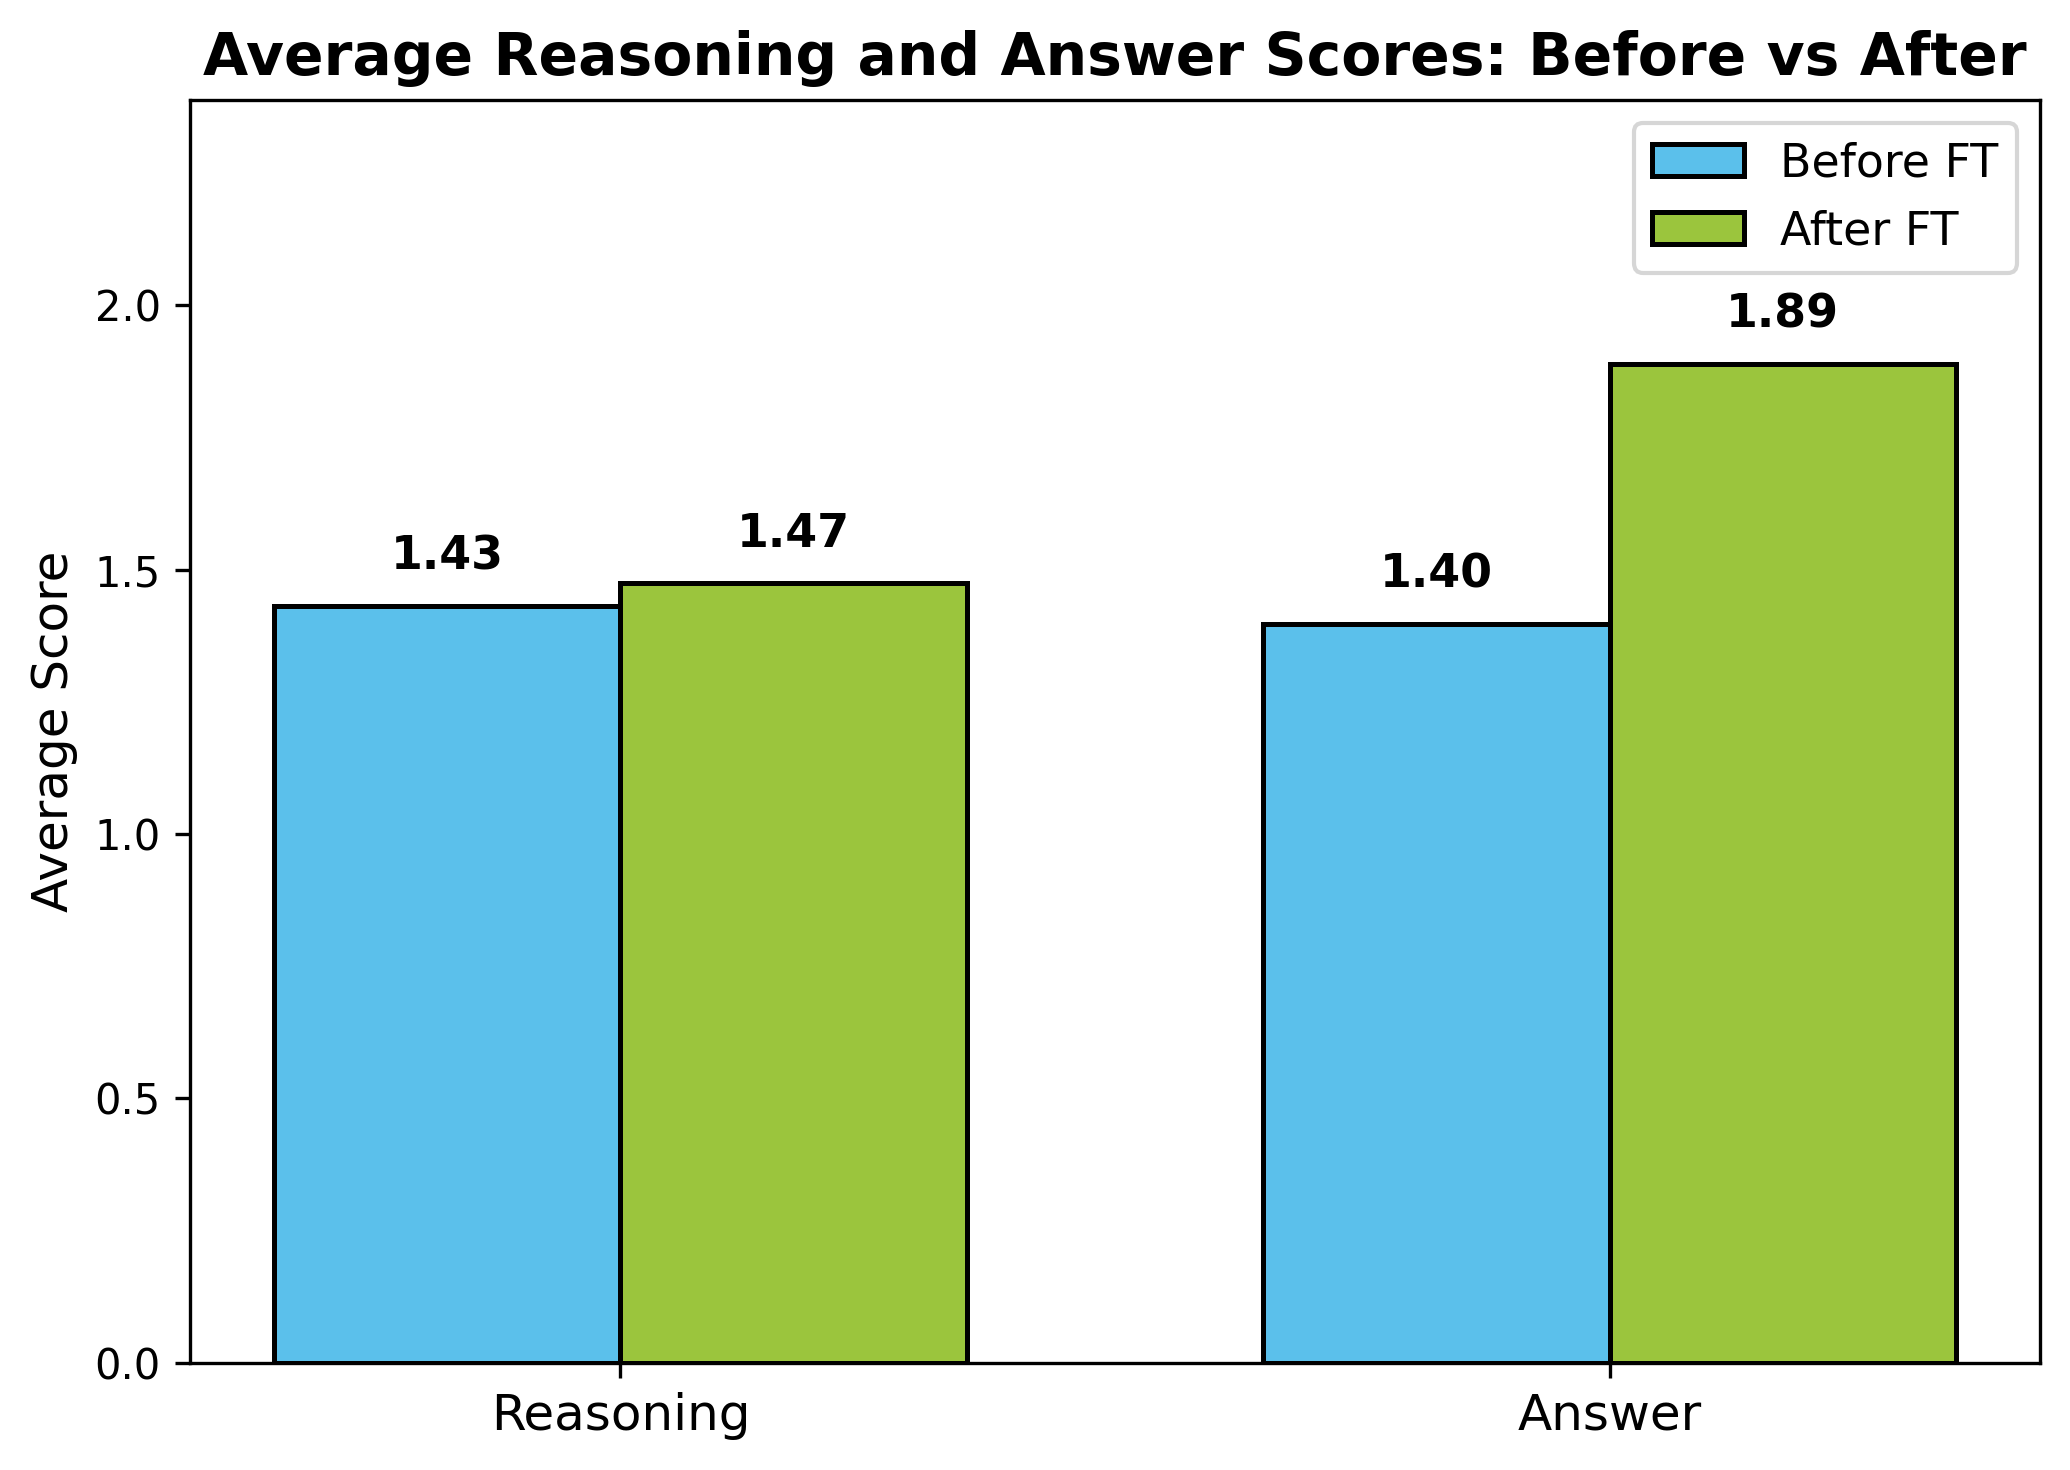

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate average scores for each category
avg_reasoning_before = combined_df["reasoning_score_before"].mean()
avg_reasoning_after = combined_df["reasoning_score_after"].mean()
avg_answer_before = combined_df["answer_score_before"].mean()
avg_answer_after = combined_df["answer_score_after"].mean()

# Data for grouped bar plot
categories = ['Reasoning', 'Answer']
before_scores = [avg_reasoning_before, avg_answer_before]
after_scores = [avg_reasoning_after, avg_answer_after]

x = np.arange(len(categories))  # label locations
width = 0.35  # width of the bars

plt.style.use('seaborn-v0_8-colorblind')
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)

bars1 = ax.bar(x - width/2, before_scores, width, label='Before FT', color='#5bc0eb', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, after_scores, width, label='After FT', color='#9bc53d', edgecolor='black', linewidth=1.2)

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Average Score', fontsize=12)
ax.set_title('Average Reasoning and Answer Scores: Before vs After', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, max(before_scores + after_scores) + 0.5)
ax.legend(fontsize=11)

# Annotate bars with values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.05, 
            f"{height:.2f}", 
            ha='center', va='bottom', fontweight='bold', fontsize=11
        )

plt.tight_layout()
plt.savefig("avg_reasoning_answer_before_after.png", dpi=300)
plt.show()


In [27]:
# Plot and save two separate stacked bar charts as PNGs: one for reasoning scores, one for answer scores (before/after)
import numpy as np

labels = ['Before', 'After']
score_values = [0, 1, 2, 3]
score_labels = ['Score=0', 'Score=1', 'Score=2', 'Score=3']
colors = ['#d73027', '#fc8d59', '#fee08b', '#1a9850']  # Prettier color palette

# Reverse for stacking order: 3 (top) to 0 (bottom)
score_values_rev = score_values[::-1]
score_labels_rev = score_labels[::-1]
colors_rev = colors[::-1]

def get_score_percents(col_prefix):
    score_percents = []
    for x in ['before', 'after']:
        col = f"{col_prefix}_score_{x}"
        counts = [(combined_df[col] == s).mean() * 100 for s in score_values_rev]
        score_percents.append(counts)
    return np.array(score_percents)  # shape (2, 4)

# Plot for reasoning and save as PNG
reasoning_percents = get_score_percents("reasoning")
x = np.arange(len(labels))
bar_width = 0.5

plt.style.use('seaborn-v0_8-colorblind')
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)

bottom = np.zeros(len(labels))
for i, (score_label, color) in enumerate(zip(score_labels_rev, colors_rev)):
    bars = ax.bar(x, reasoning_percents[:, i], bar_width, bottom=bottom, label=score_label, color=color, edgecolor='black', linewidth=0.7)
    for j in range(len(labels)):
        if reasoning_percents[j, i] > 2:  # Only label if >2% for clarity
            ax.text(
                x[j], 
                bottom[j] + reasoning_percents[j, i]/2, 
                f"{reasoning_percents[j, i]:.1f}%", 
                ha='center', 
                va='center', 
                color='black' if i != (len(score_labels_rev)-1) else 'white', 
                fontweight='bold',
                fontsize=10
            )
    bottom += reasoning_percents[:, i]

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Distribution of Reasoning Scores (3, 2, 1, 0): Before vs After', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.legend(
    title='Score',
    fontsize=10,
    title_fontsize=11,
    loc='center',
    bbox_to_anchor=(0.5, 0.5),
    frameon=True
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("reasoning_score_distribution_before_after.png", dpi=300)
plt.close(fig)  # Close the figure to avoid display in notebook

# Plot for answer and save as PNG
answer_percents = get_score_percents("answer")
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)

bottom = np.zeros(len(labels))
for i, (score_label, color) in enumerate(zip(score_labels_rev, colors_rev)):
    bars = ax.bar(x, answer_percents[:, i], bar_width, bottom=bottom, label=score_label, color=color, edgecolor='black', linewidth=0.7)
    for j in range(len(labels)):
        if answer_percents[j, i] > 2:  # Only label if >2% for clarity
            ax.text(
                x[j], 
                bottom[j] + answer_percents[j, i]/2, 
                f"{answer_percents[j, i]:.1f}%", 
                ha='center', 
                va='center', 
                color='black' if i != (len(score_labels_rev)-1) else 'white', 
                fontweight='bold',
                fontsize=10
            )
    bottom += answer_percents[:, i]

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Distribution of Answer Scores (3, 2, 1, 0): Before vs After', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.legend(
    title='Score',
    fontsize=10,
    title_fontsize=11,
    loc='center',
    bbox_to_anchor=(0.5, 0.5),
    frameon=True
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("answer_score_distribution_before_after.png", dpi=300)
plt.close(fig)  # Close the figure to avoid display in notebook


In [23]:
r = '''Co-hosting performance does **not** count toward Superhost eligibility. Superhost status is determined solely by your **own listings** and their performance metrics (e.g., response time, acceptance rate, review scores).  

**Detailed Explanation:**  
1. **Superhost Criteria Focus:** Airbnb’s Superhost status is based on your **own properties**. Metrics like response time, acceptance rate, and review scores are calculated per listing you own, not co-hosted properties.  
2. **Co-Hosting Doesn’t Count:** While co-hosting contributes to the host’s overall experience (e.g., shared responsibilities, guest interactions), it does **not** impact Superhost qualification.  
3. **Own Listing Performance Matters:** To qualify for Superhost status, you must meet Airbnb’s criteria for **each of your own listings** individually. For example, if you own one listing, you’ll need to meet its performance standards.  
4. **Multiple Listings:** If you own multiple listings, each must meet the Superhost criteria separately. Co-hosting additional properties does not grant Superhost status for your own listings.  

**Next Steps for Maria:**  
- Focus on improving her **own listing’s performance** (response time, communication, cleanliness, etc.).  
- Check if her own listing meets the Superhost criteria (e.g., 90%+ response rate, 90%+ acceptance rate, 4.8+ average review score).  
- If she has multiple own listings, ensure each meets the criteria individually.  

**Policy Reference:**  
Airbnb’s [Superhost Eligibility Guidelines](https://www.airbnb.com/help/article/38722) state that Superhost status is determined by your own listings and their performance, not co-hosting activity.  

Maria can apply for Superhost status by focusing on her own listing’s metrics and ensuring she meets the criteria for that property.'''

rubric_result = score_ai_response(
        question=downloaded_dataset['test'][40]['situation'],
        ai_response=r,
        ground_truth=downloaded_dataset['test'][40]['solution']
    )
rubric_result

ScoreResponse(reasoning="The AI response accurately reflects the ground truth that co-hosting performance does not count toward Superhost eligibility and that only the performance of listings where Maria is the listing owner will be considered. The AI response provides a detailed explanation that aligns with the ground truth, emphasizing that Superhost status is determined by the performance metrics of the host's own listings. It also correctly outlines the criteria that Maria needs to meet for her own listing to qualify for Superhost status. The response is comprehensive and matches the ground truth exactly in terms of content and meaning.", score=3)

In [1]:
%env HF_TOKEN=your-huggingface-token-here


env: HF_TOKEN=your-huggingface-token-here


In [46]:
# 1. install the integrations
# pip install langgraph langchain langchain-huggingface

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_huggingface import HuggingFacePipeline  # wraps 🤗 pipeline
from langchain_huggingface import ChatHuggingFace      # makes it a BaseChatModel
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

# 2. load your local HF model and tokenizer
model_id = "Qwen/Qwen3-0.6B"  # or any HuggingFace repo ID
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)


In [47]:
# 3. create a transformers pipeline
hf_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=512,
    temperature=0.2,
)

Device set to use mps:0


In [48]:
pipeline_wrapper = HuggingFacePipeline(pipeline=hf_pipeline)
pipeline_wrapper

HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x16d537410>, model_id='Qwen/Qwen3-0.6B')